# Creating AI dataset to test azimuthal integration


## from Dectris/Eiger 4M data to Jungfrau Format 





In [1]:
import os,numba
import numpy as np

import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

%matplotlib notebook


savedir = '/segfs/deg/working/ponsard/Detector/paper1/'

ImportError: No module named 'numba'

In [2]:
import numba

@numba.jit(nopython=True)
def func(ds):
   
        
    return data




# 

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import RashpaFrontEnd as rp
import numpy as np
import cv2
from PIL import Image






ImportError: No module named 'cv2'

## create dataset,

- add noise
- center
- mask


In [4]:
# w,h,n=2048,2048,100
w,h,n=1024,512,100
d=np.ones(w*h*n,dtype=np.uint16)
d=d.reshape((n,h,w))

for i in range(n):
    for n in range(5):
        r = int(w/2*np.random.rand())
        d[i]=cv2.circle(d[i],(int(w/2),int(h/2)),r,(100,0,0))
        
savedir = '/segfs/deg/working/ponsard/Detector/paper1/'    
d.tofile(savedir+'pyfaids.data')

In [19]:
d.shape

(100, 512, 1024)

<IPython.core.display.Javascript object>


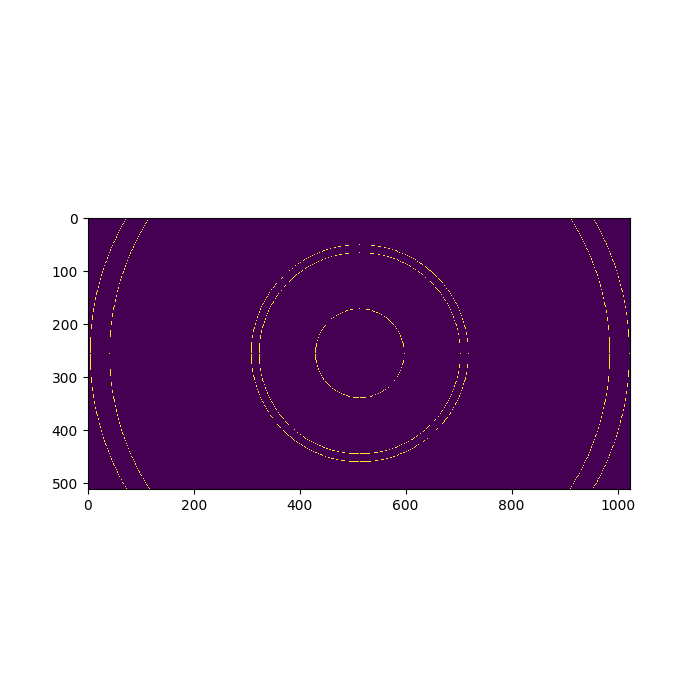

In [5]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.imshow(d[0])#,norm=LogNorm(vmin=1, vmax=10))

# Build all

In [25]:
import numba

@numba.jit(nopython=True)
def createDsWithInterPedestal2(ds):
    gmask=[0,                  #not used
       0b0100000000000000, #G0
       0b1000000000000000, #G1
       0b1100000000000000] #G2
    nImg,jf_mh,jf_mw = ds.shape
    jfimg = np.copy(ds)
    jf_raw_pe = np.zeros((2*nImg,ds.shape[1],ds.shape[2]),dtype=np.uint16)
    #suppress invalid pixel CHECKME
#     jfimg[jfimg>6]=0
    
#   #create pseudo pedestal
    p = np.random.random(nImg*jf_mh*jf_mw)
    p = p.astype(np.uint16)
    p = p.reshape((nImg,jf_mh,jf_mw))
    p = (4*p)
    pedestal         = np.zeros((4,nImg,jf_mh,jf_mw),dtype=np.uint16)
    pedestal[1]      = p #pedestal non null only for first gain G0
    
    for i in range (nImg):
        for x in range(ds.shape[1]):
            for y in range(ds.shape[2]):
#               #compute JF raw data with random gain (same r per image)
                r = np.random.randint(3)+1 #gain in [1,2,3]
                a = np.uint16(jfimg[i][x][y]*gain[r][x][y]+pedestal[r][i][x][y])
                if a > 0b0011111111111111: 
                    print('overflow',jfimg[i][x][y],gain[r][x][y],pedestal[r][i][x][y])
#                
                jf_raw_pe[2*i][x][y] = np.uint16(a) | gmask[np.uint16(r)] 
                
#                 #add pedestal intermediate image
                jf_raw_pe[2*i+1][x][y] = pedestal[r][i][x][y]
        
    return jf_raw_pe

In [31]:

@numba.jit(nopython=True)
def applyCorrection2(ds):
    nImg = int(ds.shape[0]/2)
    rc = np.zeros((nImg,512,1024),dtype=np.uint16)
    for i in range(nImg):
        for x in range(ds.shape[1]):
            for y in range(ds.shape[2]):
                img   = ds[2*i][x][y]
                pedes = ds[2*i+1][x][y]

                r = img>>14
                if r==0:
                    print('gain factor error')
                res = ((img & 0b0011111111111111)-pedes) / gain[r][x][y] 
#                 if (res>6):
#                     print('max error',i,res)
 
                rc[i][x][y] = np.uint16(round(res))
    return rc

In [35]:
gain = np.fromfile('/tmp/gain500k.data',dtype=np.float32)
gain = gain.reshape(4,512,1024)
# g4 = np.zeros(4*512*1024*8,dtype=np.float32)
# g4 = g4.reshape((4,2048,2048))
# for c in [0,1]:
#     for r in [0,1,2,3]:
#          #print(c,r)
#         g4[1,r*512:(r+1)*512,c*1024:(c+1)*1024] = gain[1]
#         g4[2,r*512:(r+1)*512,c*1024:(c+1)*1024] = gain[2]
#         g4[3,r*512:(r+1)*512,c*1024:(c+1)*1024] = gain[3]
# g4.tofile(savedir+'g4.data')

In [39]:
gain.tofile(savedir+'gain500k.data')

In [44]:
ls '/segfs/deg/working/ponsard/Detector/paper1/'


g4.data  gain500k.data  lz_500k_100.data  pyfaids.data


In [28]:
d_p_g = createDsWithInterPedestal2(d)


In [36]:
c = applyCorrection2(d_p_g)

<IPython.core.display.Javascript object>


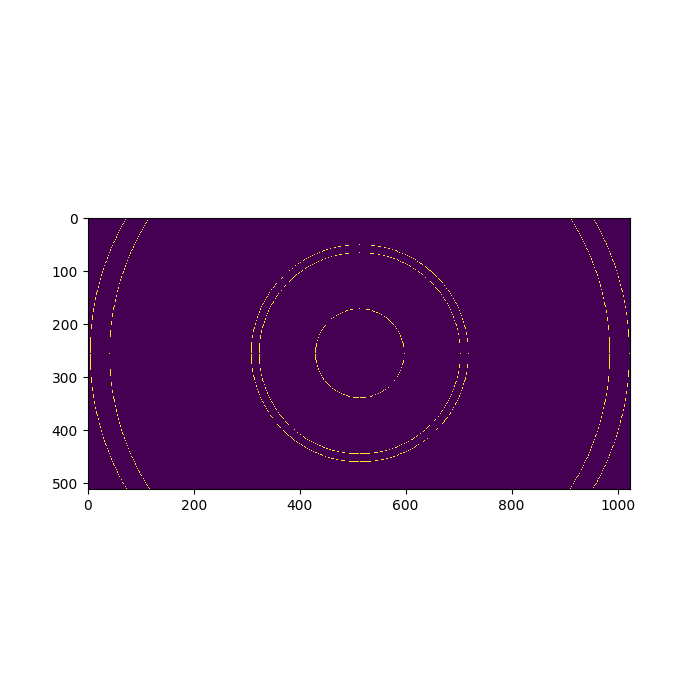

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.imshow(c[0])#,norm=LogNorm(vmin=1, vmax=10))

In [30]:
d_p_g.shape,d_p_g.dtype

((200, 512, 1024), dtype('uint16'))

In [38]:
d_p_g.tofile('/tmp/pyfai_p_g.data')

In [ ]:
ds.shape